In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import numpyro
import numpyro.distributions as dist
import jax
plt.style.use('seaborn-darkgrid')

## ベルヌーイモデル

$$
Y_i \sim {\rm Bernoulli}(q), \ \ i=1,\dots, n \\
q \sim {\rm Beta}(a, b)
$$

データの読み込み

In [2]:
data = np.loadtxt("./ch08/Fujii.txt")
data

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.])

モデル

In [3]:
def model(data):
    q = numpyro.sample("q", dist.Beta(1, 1))
    with numpyro.plate("data", size = len(data)):
        y = numpyro.sample("y", dist.Bernoulli(q), obs=data)

In [4]:
kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(kernel, num_samples=1000, num_warmup=300)
mcmc.run(jax.random.PRNGKey(0), data)

sample: 100%|██████████| 1300/1300 [00:06<00:00, 205.79it/s, 3 steps of size 1.12e+00. acc. prob=0.89]


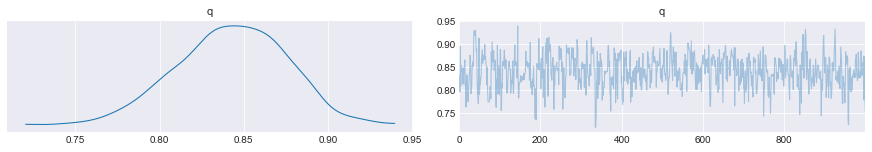

In [5]:
az.plot_trace(mcmc);

In [6]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         q      0.84      0.03      0.84      0.78      0.89    373.73      1.00

Number of divergences: 0


## 先手後手を考慮したベルヌーイモデル

$$
Y_i \sim {\rm Bernoulli}(x_iq_1+(1-x_i)q_0), \ \ i=1,\dots, n \\
q_0 \sim {\rm Uniform}(0, 1) \\
q_1 \sim {\rm Uniform}(0, 1)
$$

データの読み込み

In [7]:
# win, first
data_first = np.loadtxt("./ch08/Fujii_first.txt", delimiter="\t", skiprows=1)
data_first[:3]

array([[1., 0.],
       [1., 1.],
       [1., 0.]])

モデル

In [8]:
def model_2(data):
    q_0 = numpyro.sample("q_0", dist.Uniform(0, 1))
    q_1 = numpyro.sample("q_1", dist.Uniform(0, 1))
    with numpyro.plate("data", size = len(data)):
        win, first = data[:, 0], data[:, 1]
        q = first * q_0 + (1 - first) * q_1
        y = numpyro.sample("y", dist.Bernoulli(q), obs=win)

In [9]:
kernel_2 = numpyro.infer.NUTS(model_2)
mcmc_2 = numpyro.infer.MCMC(kernel_2, num_samples=1000, num_warmup=300)
mcmc_2.run(jax.random.PRNGKey(0), data_first)

sample: 100%|██████████| 1300/1300 [00:06<00:00, 214.00it/s, 3 steps of size 8.67e-01. acc. prob=0.91] 


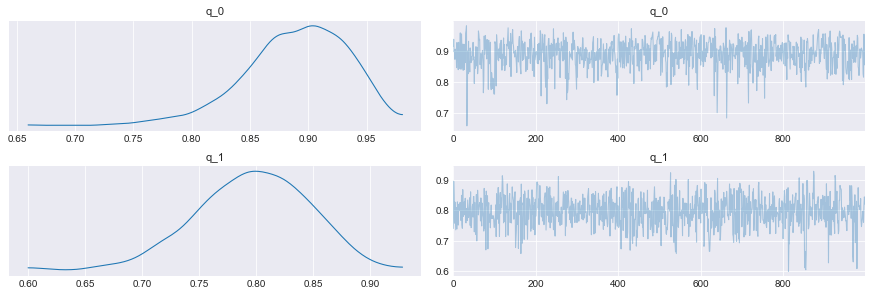

In [10]:
az.plot_trace(mcmc_2);

In [11]:
mcmc_2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       q_0      0.89      0.05      0.89      0.83      0.97    622.36      1.00
       q_1      0.80      0.05      0.80      0.71      0.88    774.39      1.00

Number of divergences: 0
